# Universidad de Chile
### Facultad de Ciencias, Física y Matemáticas
### Departamento de Ciencias de la Computación
### CC5508 - Procesamiento y Análisis de imágenes
### Tarea 5 - Mejoramiento de huellas dactilares
### Gabriel De La Parra

# Introducción
El objetivo de la presente tarea es realizar un mejoramiento de huellas dactilares al aplicar un filtro de Gabor sobre las curvas propias de la huella.

El procedimiento a seguir consiste en calcular, utilizando filtros Sobel (Horizontal y Vertical) la orientación del pliegue de la huella. Sobre dicha orientación calcular el filtro Gabor.

El presente documento entrega un proceso descriptivo lógico sobre el cual se trabajo y se desarrolló la tarea. Dicho proceso consistió en levantar la infraestructura necesaria para poder realizar la visualización y analizar los resultados en primera instancia. Esto es un cambio significativo con experiencias anteriores, en dónde primero se ha intentado resolver el algoritmo, para luego visualizar los resultados. En el nuevo acercamiento, es posible lograr una visualización inmediata sobre los algoritmos implementados.

En esta tarea se trabajó nuevamente con Jupyter, por sus prestaciones para poder visualizar el código on-the-go y la facilidad de generar aplicaciones dinámicas que permitan realizar mejores ajustes sobre los resultados obtenidos.

Si bien los resultados obtenidos no son de todo satisfactorios, se logró un aprendizaje sustentable sobre la técnica del cálculo de las orientaciones. La aplicación del filtro Gabor se entiende según lo desarrollado, sin embargo, la complejidad estuvo en realizar la correlación. Este proceso se estima fue mal concevido, sin embargo, la lógica detrás se considera entendida. La implementación se intentó de varias maneras: Convolución en 2D, iterando sobre las dimensiones del filtro y con funciones existentes en la web. 

El autor considera, que dadas las presiones de las últimas semanas del semestre, fue dificil completar esta tarea, de todas formas se abordó con suficiente tiempo, sin poder finalmente concretar, como se mencionó anteriormente en la implementación de la correlación.

# Desarrollo
El desarrollo de esta tarea está compuesta de las siguientes etapas: 
1. Filtro Gabor y pruebas.
2. Infraestructua para pruebas.
3. Cálculo de orientaciones.
4. Pruebas con imágenes reales.
5. Correlación entre filtro y orientaciones.

## Imports
El siguiente bloque de código contiene las librerías utilizadas.

In [1]:
%matplotlib inline

import os
from scipy import ndimage as ndi, signal
from skimage import io, filters, exposure, color, img_as_float
import matplotlib.pylab as plt
import matplotlib
import numpy as np
from ipywidgets import interact, widgets, HBox
from IPython import display
import math
from random import randint

#Ajustar el tamaño de las imágenes:
matplotlib.rcParams['figure.figsize'] = (14,12)

## Filtro de Gabor
El siguiente código fue obtenido desde la página de Wikipedia y adaptado a los requerimientos de la tarea. Se verificó el contenido para comprobar que el resultado es el mismo solicitado en el enunciado.

In [2]:
def gabor_fn(theta, Lambda, sigma_x, sigma_y):

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta)
    return gb

## Prueba Gabor

Filter Shape: (61, 61)


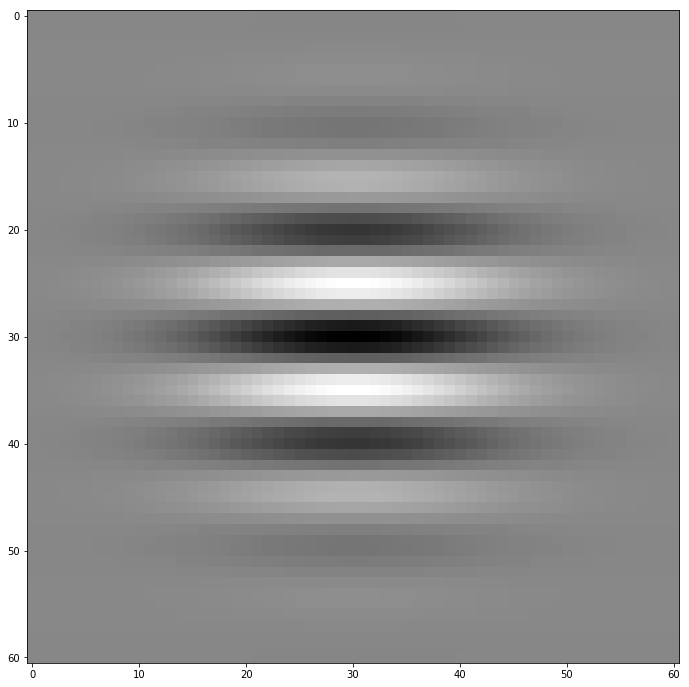

In [3]:
gabor = gabor_fn(0, 10, 10, 10)
print("Filter Shape:",gabor.shape)
plt.imshow(gabor, cmap="binary")
plt.show()

Filter Shape: (215, 215)


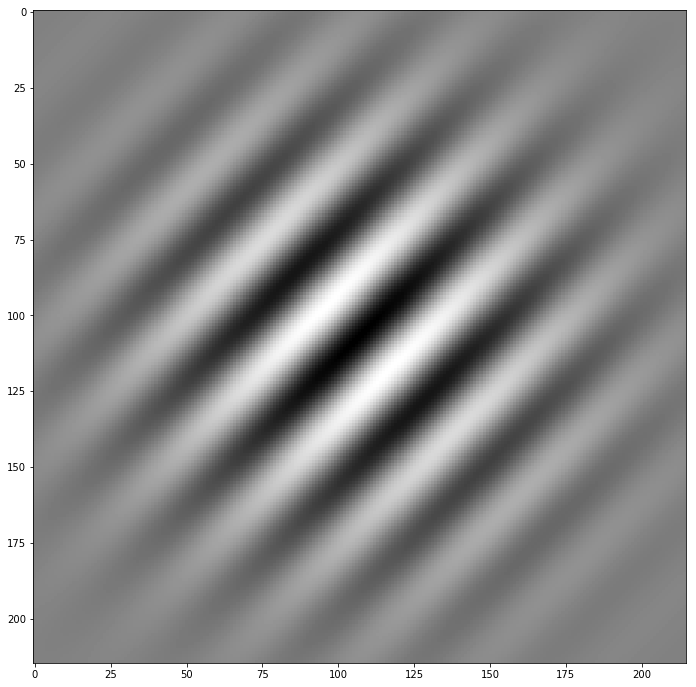

In [4]:
gabor = gabor_fn(math.pi/4, 30, 50, 50)
print("Filter Shape:",gabor.shape)
plt.imshow(gabor, cmap="binary")
plt.show()

## Gabor dinámico: Prueba de parámetros

In [5]:
def testGabor(theta = math.pi/4, Lambda = 30, sigma_x=40, sigma_y=40):
    gabor = gabor_fn(theta, Lambda, sigma_x, sigma_y)
    plt.imshow(gabor, cmap="binary")
    print("Filter Shape:",gabor.shape)
    plt.show()
    
interact(testGabor, theta = (0, math.pi), Lambda = (0,100), sigma_x=(0,100), sigma_y=(0,100))
print("Gabor Interactivo")

Widget Javascript not detected.  It may not be installed or enabled properly.


Gabor Interactivo


## Celdas de pixeles

In [6]:
W = 4
for i in range(W*W):
    print(math.floor(i/W))

0
0
0
0
1
1
1
1
2
2
2
2
3
3
3
3


## Demo Celdas: Celdas por imagen

In [7]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellSize, cellSize, cellCount))
    print(cellCount)
    
createCellDemo(64,4) 

16


## Demo Celdas: Índices celdas

In [8]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    x = 0
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellY * cellCount + cellX
            if x < 16:
                print("i:",i,"j:", j,"cellX:", cellX,"cellY:", cellY,"index:", cellIndex)
                x += 1
    
createCellDemo(16,4)

i: 0 j: 0 cellX: 0 cellY: 0 index: 0
i: 1 j: 0 cellX: 0 cellY: 0 index: 0
i: 2 j: 0 cellX: 0 cellY: 0 index: 0
i: 3 j: 0 cellX: 0 cellY: 0 index: 0
i: 4 j: 0 cellX: 1 cellY: 0 index: 1
i: 5 j: 0 cellX: 1 cellY: 0 index: 1
i: 6 j: 0 cellX: 1 cellY: 0 index: 1
i: 7 j: 0 cellX: 1 cellY: 0 index: 1
i: 8 j: 0 cellX: 2 cellY: 0 index: 2
i: 9 j: 0 cellX: 2 cellY: 0 index: 2
i: 10 j: 0 cellX: 2 cellY: 0 index: 2
i: 11 j: 0 cellX: 2 cellY: 0 index: 2
i: 12 j: 0 cellX: 3 cellY: 0 index: 3
i: 13 j: 0 cellX: 3 cellY: 0 index: 3
i: 14 j: 0 cellX: 3 cellY: 0 index: 3
i: 15 j: 0 cellX: 3 cellY: 0 index: 3


## Demo Celdas: Visualización celdas

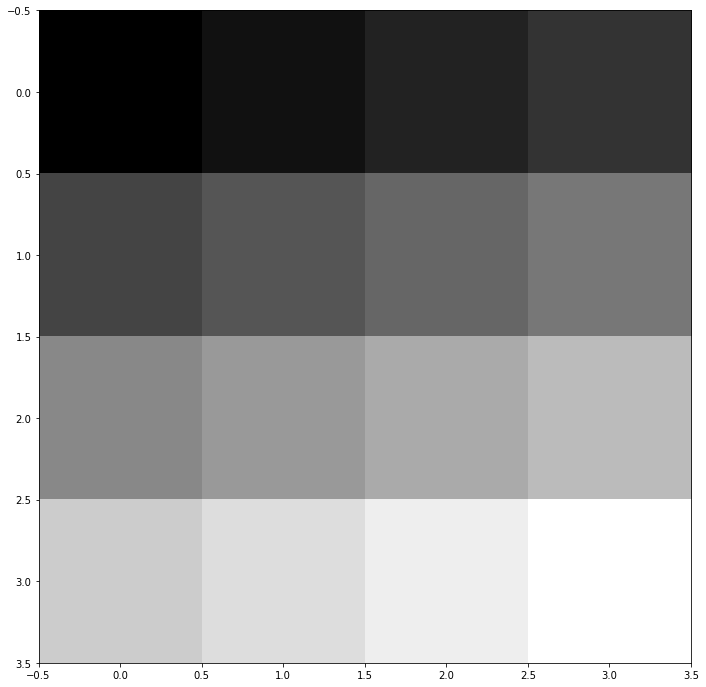

In [9]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            cellPixels[cellX, cellY] = cellIndex
    
    
    plt.imshow(cellPixels, cmap="gray")
        
createCellDemo(16,4)

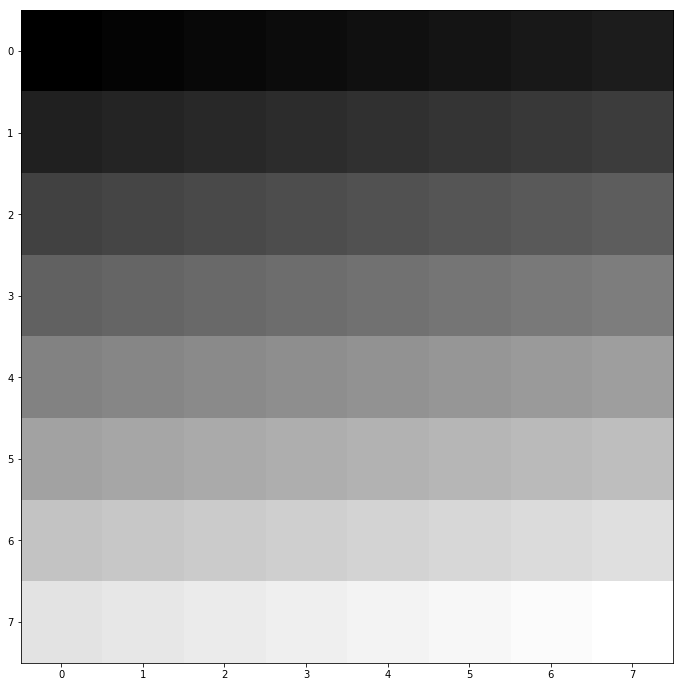

In [10]:
createCellDemo(32,4)

## Demo Celdas: Anotación en celdas

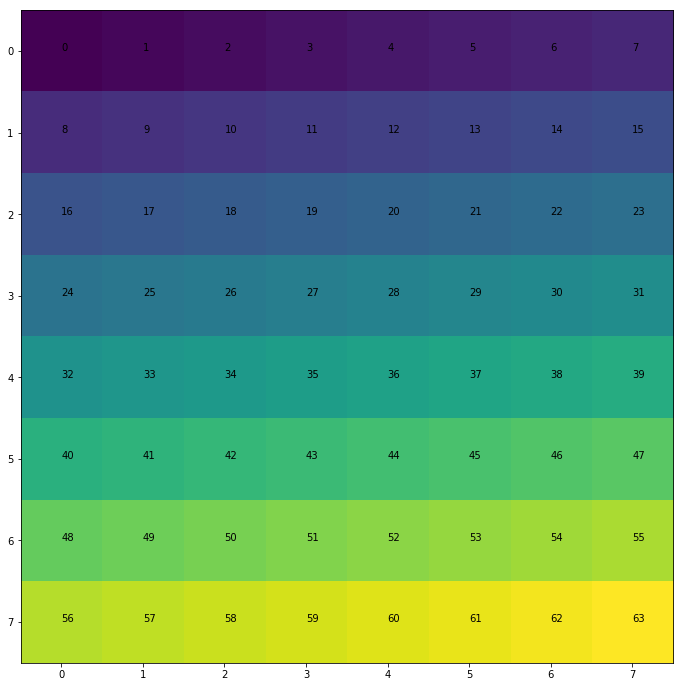

In [11]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            cellPixels[cellX, cellY] = cellIndex
    
    
    fig, ax = plt.subplots()
    ax.imshow(cellPixels)
    
    for j in range(cellPixels.shape[1]):
        for i in range(cellPixels.shape[0]):
            ax.annotate('{0:.0f}'.format(cellPixels[i,j]), (j,i))
        
createCellDemo(32,4)

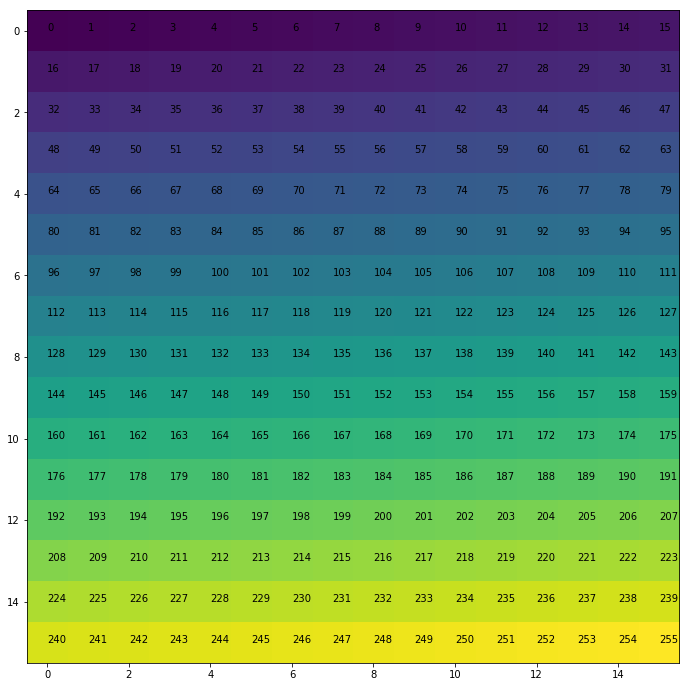

In [12]:
createCellDemo(64,4)

## Demo Celdas: Parametrizar anotaciones

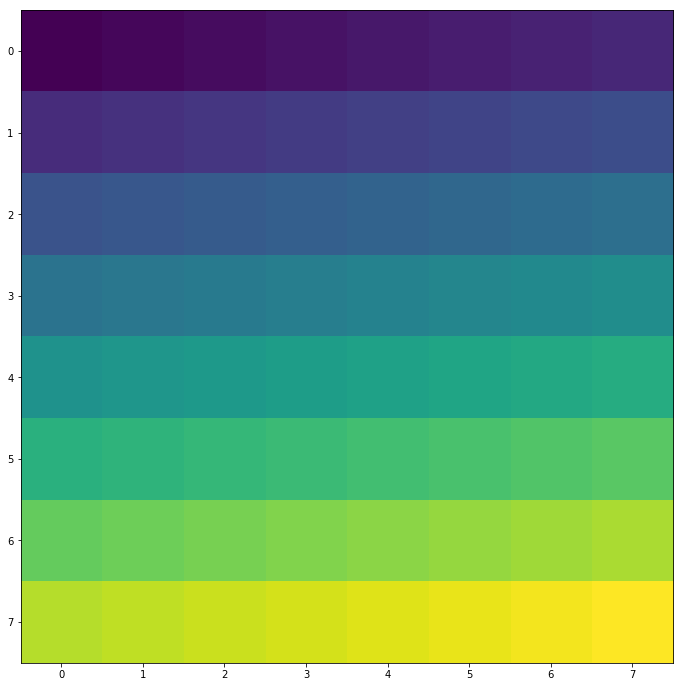

In [13]:
def decorateCells(ax, cellPixels, cellContent = None):
    if cellContent == "index":
        for j in range(cellPixels.shape[1]):
            for i in range(cellPixels.shape[0]):
                ax.annotate(cellPixels[i,j], (j,i))
                
    return ax, cellPixels

def createCellDemo(imageSize, cellSize, cellContent = None):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            if cellContent == "index" or cellContent == None:
                cellPixels[cellX, cellY] = cellIndex
    
    fig, ax = plt.subplots()
    ax, cellPixels = decorateCells(ax, cellPixels, cellContent)
    ax.imshow(cellPixels)
    
createCellDemo(32,4)

## Demo Celdas: Visualización de orientaciones

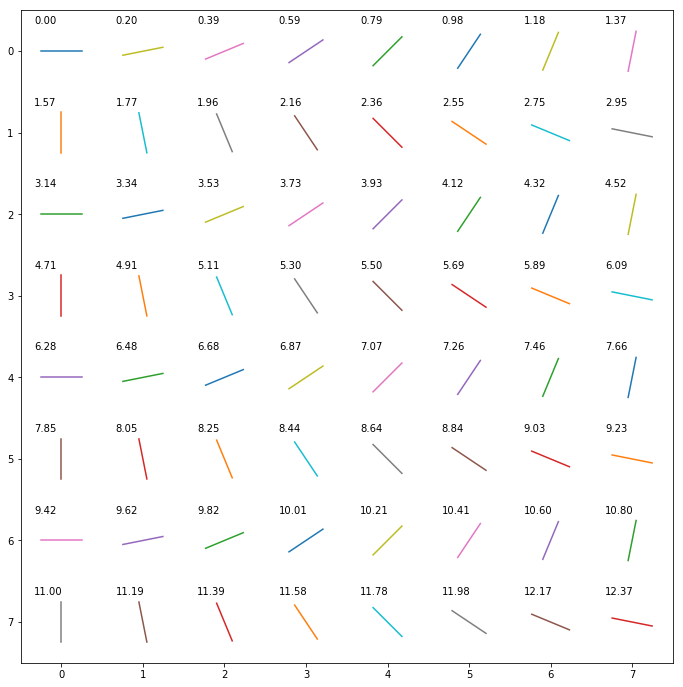

In [14]:
def decorateCells(fig, ax, cells, cellContent = None):
    if cellContent == "index":
        for j in range(cells.shape[1]):
            for i in range(cells.shape[0]):
                ax.annotate(cells[i,j], (j,i))
                
    if cellContent == "orientations":
        for j in range(cells.shape[1]):
            for i in range(cells.shape[0]):
                ax.plot([j-math.cos(cells[i,j])/4,j+math.cos(cells[i,j])/4],[i+math.sin(cells[i,j])/4,i-math.sin(cells[i,j])/4])
                ax.annotate('{:1.2f}'.format(cells[i,j]), (j-1/3,i-1/3))
                cells[i,j] = 0;

    return fig, ax, cells

def createCellDemo(imageSize, cellSize, cellContent = None):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cells = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            if cellContent == "index" or cellContent == None:
                cells[cellX, cellY] = cellIndex
            elif cellContent == "orientations":
                cells[cellX, cellY] = math.pi*cellIndex/cellCount/2
                
    fig, ax = plt.subplots()
    fig, ax, cells = decorateCells(fig, ax, cells, cellContent)
    ax.imshow(cells, cmap="binary")
    
createCellDemo(32,4, "orientations")

## Visualización: Celdas según intesidades

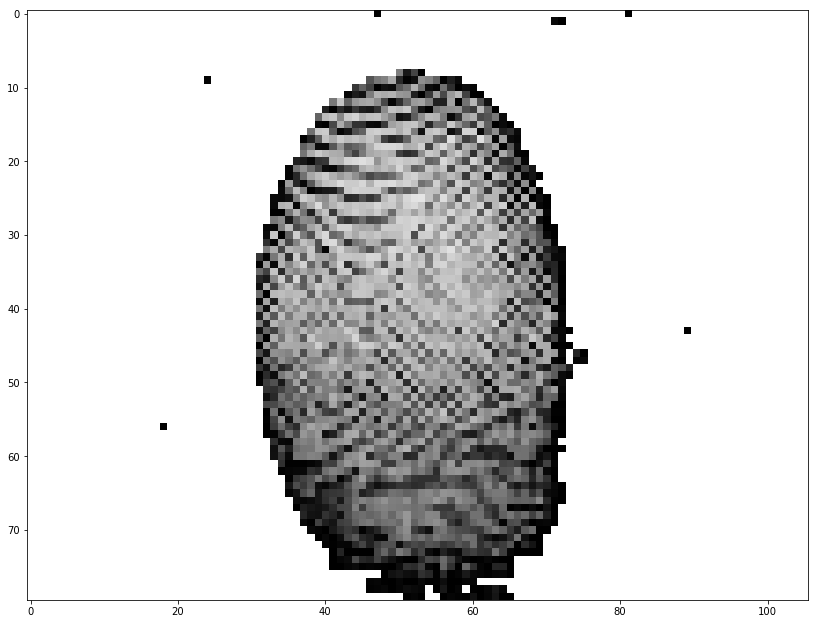

In [15]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cells = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            pixelValue = image[i,j]
            if(pixelValue<255):
                cells[cellX, cellY] = pixelValue
            
    fig, ax = plt.subplots()
    ax.imshow(cells, cmap="binary")

image = io.imread("./DB1_B/101_2.tif")
imageOrientation(image, 6)            

## Visualización: Orientación de intensidades

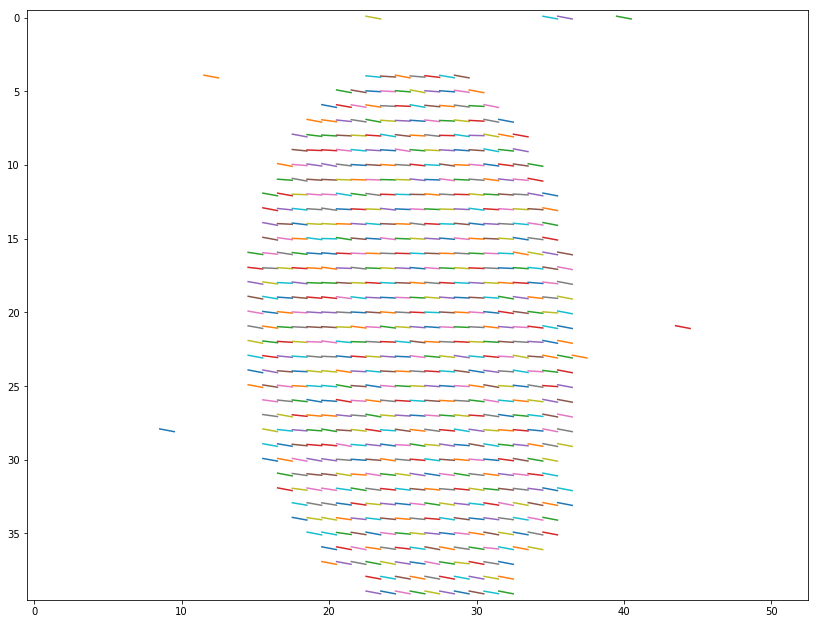

In [16]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cells = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            pixelValue = image[i,j]
            if(pixelValue<255):
                cells[cellX, cellY] = 0.5 * math.pi * pixelValue / cellCount
            
    fig, ax = plt.subplots()
    for j in range(cellCols):
        for i in range(cellRows):
            if(cells[i,j]>0):
                ax.plot([j-math.cos(cells[i,j])/2,j+math.cos(cells[i,j])/2],[i-math.sin(cells[i,j])/2,i+math.sin(cells[i,j])/2])
            cells[i,j] = 0;
                
    ax.imshow(cells, cmap="binary")

imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
imageOrientation(image, 12)    

## Orientación: Algoritmo de orientaciones

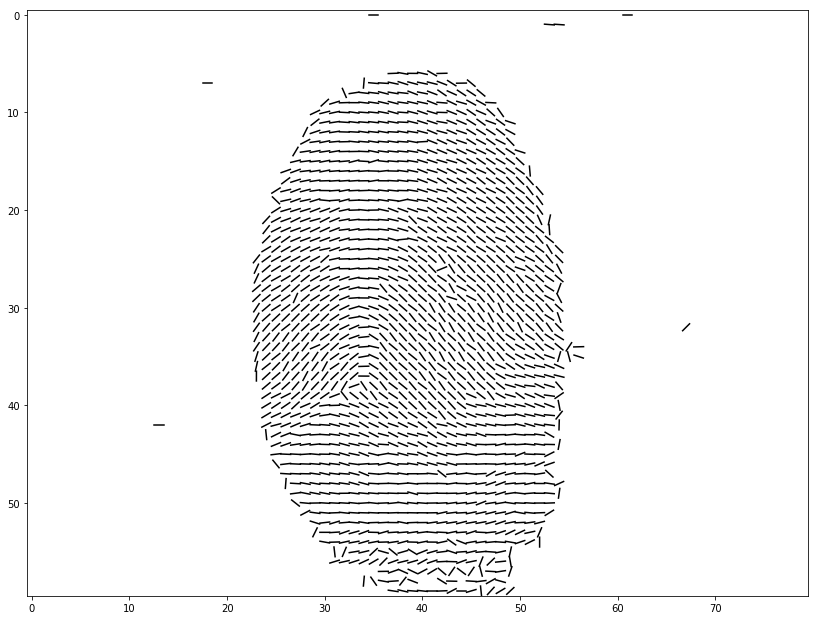

In [17]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols

    sobelH = filters.sobel_h(image)
    sobelV = filters.sobel_v(image)
    
    cells = np.zeros((cellRows, cellCols)) 
    m_sines = np.zeros((cellRows, cellCols)) 
    m_cosines = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            if(image[i,j] == 255):
                continue
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            gx = sobelH[i,j]
            gy = sobelV[i,j]
            alfa = math.atan2(gy, gx)
            mag = math.sqrt(gx * gx + gy * gy)
            m_sines[cellX, cellY] = m_sines[cellX, cellY] + 2 * math.cos(alfa) * math.sin(alfa) * mag
            m_cosines[cellX, cellY] = m_cosines[cellX, cellY] + (math.cos(alfa) * math.cos(alfa) - math.sin(alfa) * math.sin(alfa)) * mag
            cellValue = math.pi + 0.5*math.atan2(m_sines[cellX, cellY], m_cosines[cellX, cellY])
            cells[cellX, cellY] = cellValue
            
    fig, ax = plt.subplots()
    for j in range(cellCols):
        for i in range(cellRows):
            if(cells[i,j]> 0):
                ax.plot([j - 0.5 * math.cos(cells[i,j]), j + 0.5 * math.cos(cells[i,j])],[i + 0.5 * math.sin(cells[i,j]), i - 0.5 * math.sin(cells[i,j])], color="black")
            cells[i,j] = 0;
                
    ax.imshow(cells, cmap="binary")

imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
imageOrientation(image, 8)   

## Orientación: Pruebas sobre celdas
El siguiente bloque de código tenía la intención de probar que la selección de la celda, al iterar sobre la imagen, fuera correcta. El algoritmo selecciona efectivamente las celdas y cambia la visibilidad de una por medio.
Si bien no tiene una utilidad muy grande, se mantuvo solo porque se ve bien (estéticamente, subjetivo, obvio).

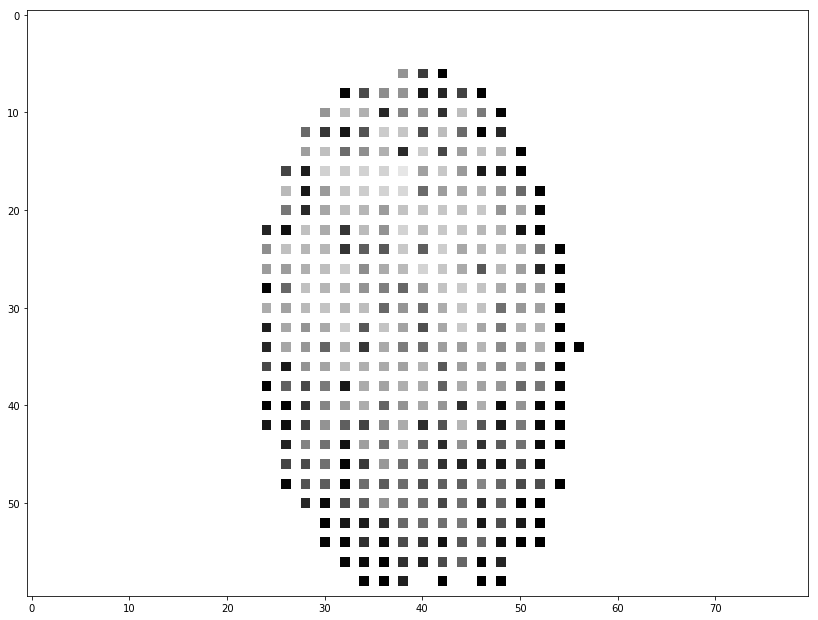

In [18]:
def segmentImagen(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cells = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            if(image[i,j] == 255):
                continue
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            if(cellX % 2==0 and cellY % 2 ==0):
                cells[cellX, cellY] = image[i,j]
    
    fig, ax = plt.subplots()
    ax.imshow(cells, cmap="binary")
    
imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
segmentImagen(image, 8)      

## Orientación: Gabor sobre orientaciones

In [19]:
def imageOrientation(image, cellSize):
    
    """Mostrar Imagen original"""
    if(False):
        print("Original Image")
        fig, ax = plt.subplots()
        ax.imshow(image, cmap="gray")
    
    """Init"""
    rows, cols = image.shape
    cellRows = math.floor(rows / cellSize)
    cellCols = math.floor(cols / cellSize)
    cellCount = cellRows * cellCols
    
    cells = np.zeros((cellRows, cellCols)) 
    m_sines = np.zeros((cellRows, cellCols)) 
    m_cosines = np.zeros((cellRows, cellCols)) 
    
    """Calcular orientaciones"""
    print("Orientations Calculations")
    sobelH = filters.sobel_h(image)
    sobelV = filters.sobel_v(image)
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i / cellSize)
            cellY = math.floor(j / cellSize)
            gx = sobelH[i, j]
            gy = sobelV[i, j]
            alfa = math.atan2(gy, gx)
            mag = math.sqrt(gx * gx + gy * gy)
            m_sines[cellX, cellY] = m_sines[cellX, cellY] + 2 * math.cos(alfa) * math.sin(alfa) * mag
            m_cosines[cellX, cellY] = m_cosines[cellX, cellY] + (math.cos(alfa) * math.cos(alfa) - math.sin(alfa) * math.sin(alfa)) * mag
            orientation = math.pi + 0.5 * math.atan2(m_sines[cellX, cellY], m_cosines[cellX, cellY])
            cells[cellX, cellY] = orientation
    
    """Mostrar orientaciones"""
    if(False):
        print("Image Orientations")
        fig, ax = plt.subplots()
        arrowCells = np.zeros_like(cells)
        for j in range(cellCols):
            for i in range(cellRows):
                if(cells[i,j]> 0):
                    ax.plot([j - 0.5 * math.cos(cells[i,j]), j + 0.5 * math.cos(cells[i,j])],[i + 0.5 * math.sin(cells[i,j]), i - 0.5 * math.sin(cells[i,j])], color="black")

        ax.imshow(arrowCells, cmap="binary")
    
    """Diccionario de filtros. Se utilizó programación dinámica para evitar calcular el filtro cada vez."""
    print("Filters Calculations")
    gaborFilters = []
    for j in range(cellCols):
        for i in range(cellRows):
            orientation = cells[i, j]
            current = [item for item in gaborFilters if item['o'] == orientation]
            if(not current):
                gaborFilters.append({'o':orientation, 'f': gabor_fn(orientation, 10, 10, 10)})                
                
    """Mejorar imagen"""
    improvedImage = np.zeros((rows, cols))
    
    print("Convolve:")
    #total = rows * cols
    #progress = 0
    #for j in range(cols):
    #    for i in range(rows):
    #        progress += 1
    #        """El proceso tomaba mucho tiempo por lo que se utilizaron mensajes para indicar el estatus."""
    #        if(progress % (total/10) == 0):
    #            print(progress/total*100, "%")
    #            
    #        cellX = math.floor(i / cellSize)
    #        cellY = math.floor(j / cellSize)
    #        orientation = cells[cellX, cellY]
    #        gabor = [item for item in gaborFilters if item['o'] == orientation]
    #        gaborX, gaborY = gabor[0]['f'].shape
    #        pixelSum = 0
            #for x in range(gaborX):
            #    for y in range(gaborY):
            #for x in range(-gaborX, gaborX):
            #    for y in range(-gaborY, gaborY):
                    #if (i+x >= 0) and (j+y >= cols) and (i+x < rows) and (j+y < cols):
                       #pixelSum += gabor[0]['f'][x,y] * image[i+x,j+y]
                        #pixelSum += gabor[0]['f'][x,y] * image[i+x,j+y]
                        #pixelSum += np.correlate(gabor[0]['f'][x,y], image[i+x,j+y])
            #print(gabor[0]['f'].shape)
            
            #improvedImage[i,j] = np.correlate(gabor[0]['f'], image[i,j])
            
            #improvedImage[i,j] += corr
            #for x in range(gaborX):
            #    for y in range(gaborY):
            #        if (i+x < rows) and (j+y < cols):
            #            pixelSum += gabor[0]['f'][x,y] * image[i+x,j+y]
            #        
            #            #pixelSum += gabor2[x, y] * image[i + x, j + y]
            #            pixelSum += gabor[0]['f'][x, y] * image[i + x, j + y]
            #improvedImage[i,j] = pixelSum
            
    #progress = 0
    #total = cellCols * cellRows
    #for j in range(cellCols):
    #    for i in range(cellRows):
    #        progress += 1
    #        """El proceso tomaba mucho tiempo por lo que se utilizaron mensajes para indicar el estatus."""
    #        if(progress % (total/10) == 0):
    #            print(progress/total*100, "%")
    #            
    #        orientation = cells[i, j]
    #        gabor = [item for item in gaborFilters if item['o'] == orientation]
    #        gabor = gabor[0]['f']
    #        gaborX, gaborY = gabor.shape
    #        pixelSum = 0
    #        for x in range(gaborX):
    #            for y in range(gaborY):
    #                for n in range(cellSize * i, cellSize * (i+1)):
    #                    for m in range(cellSize * j, cellSize * (j+1)):
    #                        pixelSum += gabor[x,y] * image[n, m]
    #        improvedImage[x,y] = pixelSum
    #        #filtered = signal.correlate2d(image[(cellSize * i) : (cellSize) * (i + 1), (cellSize * j) : (cellSize) * (j + 1)], gabor_fn(orientation, 10, 10, 10), mode="same")
    #        #improvedImage[(cellSize * i) : (cellSize) * (i + 1), (cellSize * j) : (cellSize) * (j + 1)] = filtered
   # 
   # fig, ax = plt.subplots()
   # ax.imshow(improvedImage, cmap="gray")
#imageFile = "./DB1_B/103_1.tif"
imageFile = "./imagen2.png"
image = io.imread(imageFile, as_grey=True)
imageOrientation(image, 10)   

Orientations Calculations
Filters Calculations
Convolve:


## Resultados

Como se puede apreciar anteriormente en la etapa del desarrollo, el proceso del cálculo de las orientaciones corresponde a los pliegues de las huellas dactilares.

Por su parte, el filtro de Gabor, corresponde a lo expuesto en la teoría, mostrando la atenuación de una función coseno sobre la curva de una exponencial.

Lo único que queda pendiente de esta experiencia es poder realizar la aplicación del filtro sobre la imagen.

Para lo anterior se realizaron múltiples intentos, sin embargo, ninguno con resultados satisfactorios. Se puede apreciar en las siguientes imágenes algunos resultados de la combinación de las orientaciones con el filtro y su aplicación a la imangen original:

![Results 1](badResult1.PNG)

![Results 2](correlate2d_bad1.PNG)

![Results 3](correlate2d_bad2.PNG)

El cálculo de los resultados 2 y 3 anteriores era rápido, sin embargo no coincidia con los resultados. Se puede apreciar que si existe una aplicación de la función de Gabor sobre cada una de las celdas, sin embargo, se estima que la proporción es distinta de la ideal. En estos dos resultados se trabajó con la correlación de 2 matrices (el filtro y el rango de la imagen)

El cálculo del primer resultado por su parte, tomó alrededor de 14 minutos para su cálculo. Se trabajó con la aplicación directa de la fórmula. Se intentó por varias formas de depurar el código, sin resultados positivos.

Se estima que revisando con mayor detalle la implementación, se podría resolver de mejor forma el problema y lograr el resultado objetivo.


## Conclusiones

Las técnicas vistas en esta experiencia permiten realizar una reconstrucción de una imagen para aumentar su calidad. Dicha reconstrucción consiste en extraer ciertas features de una imagen, en este caso, los pliegues de una huella dactilar, y posteriormente reconstruir la imagen a partir de los gradientes de dichos pliegues.

En esta experiencia se trabajó con operaciones vistas anteriormente en clase como los filtros Sobel (Detección de bordes), operaciones sobre matrices (Correlación/Convolución), y el uso de la función exponencial, combinada con una función coseno, para generar un filtro muy poderoso para detección de texturas.

Durante el desarrollo de esta tarea, se revisó bilbiografía en internet en donde se detalla que esta técnica se puede aplicar para la detección de rasgos faciales, texturas en paisajes, animales u otros. Lo anterior prueba la utilidad de las técnicas mencionadas.

El autor considera que este trabajo fue muy importante ya que permitió abordar el problema de una forma distinta, generando un avance en la metodología para abordar problemas. Se podría considerar intuitiva, sin embargo, el poder haberla 'descrubierto' fue muy iluminador. Dicha metodología consistió en primero, crear una infraestructura para probar el resultado, antes de realizar cualquier implementación. De esta forma, se pudo descartar de forma prematura cualquier problema sobre el código, al realizar iteraciones pequeñas que estén validadas. De cierta forma, se levantó una plataforma para TDD, con revisión manual.

Cabe mencionar que nuevamente se trabajó sobre Jupyter Notebook. El autor no está afiliado con dicha organización, sin embargo la encuentra una herramienta y plataforma muy poderosa para evaluar de forma interactiva y dinámica los resultados de implementaciones de algoritmos. La principal ventaja que se tiene, es que esta plataforma permite modificar parámetros de forma dinámica sin tener que modificarlos en el código y ejecutar nuevamente el código. Lo anterior permite ahorrar mucho tiempo.

Adicional a lo anterior, se permite redactar conclusiones e inferencias directamente sobre el código, manteniendo bloques funcionales de código que se pueden consultar en la línea temporal del desarrollo.

El autor considera lamentable no haber podido llegar al resultado deseado o solicitado, sin embargo, considera que el aprendizaje logrado durante esta experiencia y durante el curso son de gran beneficio para el desarrollo académico/profesional del estudiante. 

Se agradece por la presente a los profesores y auxiliar del ramo por su apoyo y paciencia durante el transcurso de este ramo.
